<a href="https://colab.research.google.com/github/ingus-t/SPAI/blob/master/Notes/chest_xrays_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Dataset on Kaggle** https://www.kaggle.com/nih-chest-xrays/data  
**Research document for this dataset:** *ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases* https://arxiv.org/abs/1705.02315

**Class count for images with only 1 class:**
```
No Finding              60361
Infiltration            9547
Atelectasis             4215
Effusion                3955
Nodule                  2705
Pneumothorax            2194
Mass                    2139
Consolidation           1310
Pleural_Thickening      1126
Cardiomegaly            1093
Emphysema                892
Fibrosis                 727
Edema                    628
Pneumonia                322
Hernia                   110
```

**Total count for all classes**
```
No_Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
```

**Accuracy achieved by transfer learning, using Resnet50 model by paper authors**
```
Atelectasis     0.7069
Cardiomegaly    0.8141
Effusion        0.7362
Infiltration    0.6128
Mass            0.5609
Nodule          0.7164
Pneumonia       0.6333
Pneumothorax    0.7891
```



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data exploration

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
from google.colab import files
from collections import Counter
import collections

In [0]:
#df = pd.read_csv("/content/Data_Entry_2017.csv")
df = pd.read_csv("Data_Entry_2017.csv") 

In [28]:
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [13]:
df.shape

(112120, 12)

In [14]:
df.dtypes

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                      int64
Patient Gender                  object
View Position                   object
OriginalImage[Width              int64
Height]                          int64
OriginalImagePixelSpacing[x    float64
y]                             float64
Unnamed: 11                    float64
dtype: object

In [88]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.872578,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.596968,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [89]:
# find count of Hernia or any other condition
df[df['Finding Labels'] == 'Hernia'].shape[0]

110

### Find all labels

In [0]:
all_classes = ['Cardiomegaly', 'No_Finding', 'Hernia', 'Infiltration', 'Nodule',
           'Emphysema', 'Effusion', 'Atelectasis', 'Pleural_Thickening',
           'Pneumothorax', 'Mass', 'Fibrosis', 'Consolidation', 'Edema',
           'Pneumonia']

### Class distribution: single class images vs multi-class images

In [0]:
# name, occurences as the only class, total occurences (including multi-class images)
distribution=[
  ["No Finding",        60361,60361],
  ["Infiltration",      9547, 19894],
  ["Atelectasis",       4215, 11559],
  ["Effusion",          3955, 13317],
  ["Nodule",            2705, 6331],
  ["Pneumothorax",      2194, 5302],
  ["Mass",              2139, 5782],
  ["Consolidation",     1310, 4667],
  ["Pleural_Thickening",1126, 3385],
  ["Cardiomegaly",      1093, 2776],
  ["Emphysema",         892,  2516],
  ["Fibrosis",          727,  1686],
  ["Edema",             628,  2303],
  ["Pneumonia",         322,  1431],
  ["Hernia",            110,  227],
]

# put data in arrays so I can use them for x, y in matplotlib
conditions, occurence_single, occurence_total, ratio = [], [] , [], []
for i in range(0, len(distribution)):
  conditions.append(distribution[i][0])
  occurence_single.append(distribution[i][1])
  occurence_total.append(distribution[i][2])
  ratio.append(distribution[i][2] / distribution[i][1])

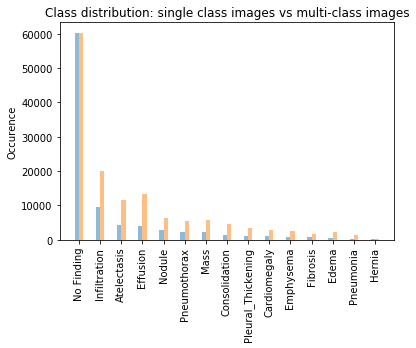

In [87]:
x_labels = np.arange(len(conditions))

indices = range(len(conditions))
width = np.min(np.diff(indices))/5.

plt.bar(indices-width/2., occurence_single, width, align='center', alpha=0.5)
plt.bar(indices+width/2., occurence_total,  width, align='center', alpha=0.5)
#plt.bar(indices+width/0.65, occurence_total, width, align='center', alpha=0.5)

plt.xticks(x_labels, conditions, rotation='vertical')
plt.ylabel('Occurence')
plt.title('Class distribution: single class images vs multi-class images')

plt.show()

### Actual class distribution for all 15 classes

In [0]:
# Find class distribution for all 15 classes: 
df['Finding Labels'] = df['Finding Labels'].str.replace('|',' ')
df['Finding Labels'].str.split(expand=True).stack().value_counts()

### Anomalies

In [0]:
# There are people with age 148 and higher, display these anomalies
df['Patient Age'].sort_values(ascending=False).head(30)

In [0]:
#get mean age
df['Patient Age'].mean()

In [0]:
# replace values that are too large with the mean
df['Patient Age'] = np.where(df['Patient Age'] > 95, 47, df['Patient Age'])

### X-ray view position

In [18]:
count = Counter(df['View Position'])
count

Counter({'AP': 44810, 'PA': 67310})

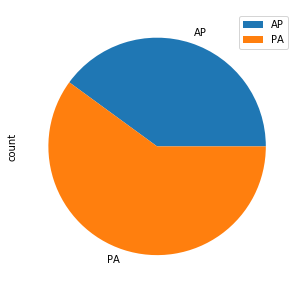

In [30]:
pie = pd.DataFrame({'count': [count['AP'], count['PA']]}, index=['AP', 'PA'])
pie.plot.pie(y='count', figsize=(5, 5))

### Gender

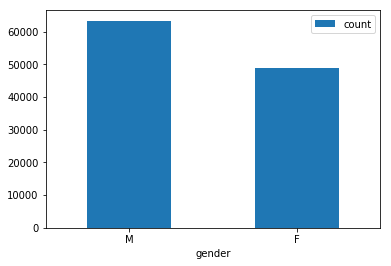

In [32]:
a = dict(Counter(df['Patient Gender']))

#draw the graph
temp_df = pd.DataFrame({'gender': list(a.keys()), 'count': list(a.values())})
ax = temp_df.plot.bar(x='gender', y='count', rot=0)

### Age distribution

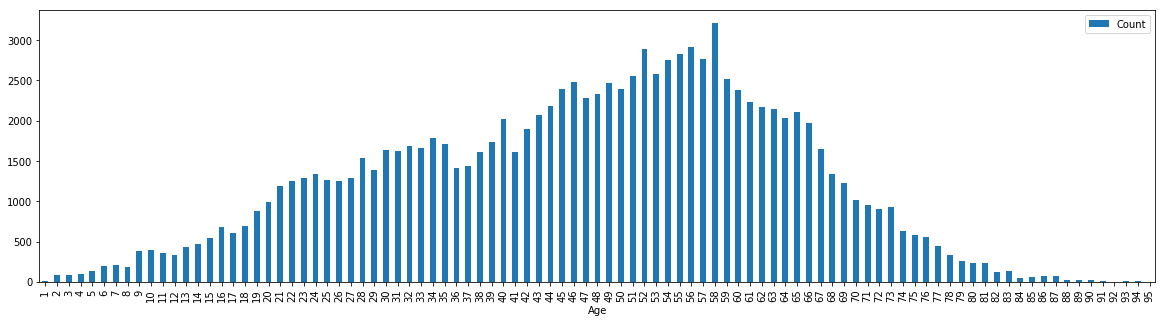

In [96]:
unordered_dict = dict(Counter(df['Patient Age']))
# make an ordered list, so the graph makes more sense
ordered_list = collections.OrderedDict(sorted(unordered_dict.items()))

#draw the graph
temp_df = pd.DataFrame({'Age': list(ordered_list.keys()), 'Count': list(ordered_list.values())})
ax = temp_df.plot.bar(x='Age', y='Count', figsize=(20,5))

In [0]:
ordered_list.keys()

In [0]:
# male + age

In [0]:
# female + age

### Medical condition label distribution
Not exactly what we need, it considers 'Hernia|Infiltration|Nodule' as 1 class, but it is actually 3.  
This gives us a total of 836 different class combinations.

In [0]:
df['Finding Labels'].value_counts()

### Condition occurence
How likely the condition is to appear as the only condition, or together with others  
1 means it only appears by itself, as the only class  
Larger value indicates the class is more likely to appear in multi-class images.
Pneumonia is the most likely to appear in multi-class images, while Infiltration is the least likely.

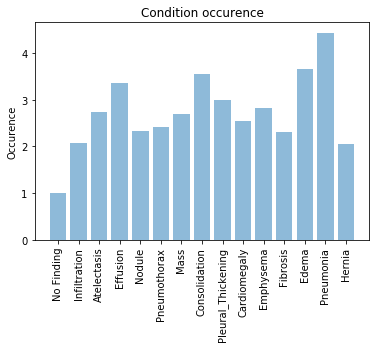

In [0]:
x_labels = np.arange(len(conditions))
plt.bar(conditions, ratio, align='center', alpha=0.5)
plt.xticks(x_labels, conditions, rotation='vertical')
plt.ylabel('Occurence')
plt.title('Condition occurence')
plt.show()

In [0]:
df['Age'].sort_values(ascending=False).head(20)

In [0]:
import PIL
from PIL import Image
import numpy as np

In [0]:
image = Image.open('00000001_000.png')

np.array(image).shape


image
#a = np.array(image)

#type(image)

### Check images from each class

# Sampling function
We decide which classes to use

In [0]:
chosen_classes = ['Cardiomegaly', 'No Finding', 'Emphysema', 'Effusion', 'Atelectasis', 'Pleural_Thickening', 'Nodule','Edema']

# create new folder for each chosen class
for i in range(0, len(chosen_classes)):
  print(chosen_classes[i])
  os.makedirs(str(chosen_classes[i]))

In [0]:
# SAMPLING FUNCTION

# take only the 2 columns we need
df1 = df[['Image Index','Finding Labels']]

# sample n random images from a specific class, resize them, and copy to train/test/valid folders
def sample_images(df1, class_name, count):
  df_samples = df1[df1['Finding Labels'] == class_name]
  df_samples = df_samples.sample(n = count)
  df_samples = df_samples[['Image Index']]
  image_names = df_samples.values

  # resize if needed

  # copy n images per class to specific folder
  for i in range(0, count):
    
    copy_from = "scans/256x256/"
    copy_to   = "scans/256x256/" + class_name + "/"
    
    shutil.copy(os.path.join(copy_from, image_names[i]), os.path.join(copy_to, image_names[i]))
  print("---")

# sample 8 classes
for j in range(0, len(chosen_classes)):
  print(j, chosen_classes[j])
  sample_images(df1, chosen_classes[j], 600)

###Download labels/image names as csv

In [0]:
df1.to_csv('labels.csv') 
files.download('labels.csv')

# Script to download all 45 GB of images
- **no longer needed**. Download from Kaggle if you want the dataset locally  
- Original function was for Python 2. In Python 3 **urlretrieve** method is moved to **request** module.  
- **Run this on your PC**, not on Colab :)

In [0]:
# Download the 56 zip files in Images_png in batches
import urllib.request

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	  'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	  'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	  'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	  'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	  'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	  'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	  'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print ('downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)  # download the zip file
print ("Download complete. Please check the checksums")